## Abstract

The purpose of this notebook is to do a QSAR model(s) for isoniazid derivatives using various machine learning algorithms. Multi-drug resistance tuberculosis (MDR-TB) is defined as resistance to the the isoniazid and rimfampicin which are the some of the first line atibiotics used in the treatment of TB. The prevalence of isoniazid resistance necessitates that new drugs are are made. The process of making drugs is termed drug development and can take on average 10 to 15 years and requires large sums of investments. Therefore, more cost effective methods are needed. Computer aided Drug Discovery CADD has the potential to reduce the cost and increase the quality of compounds taken forward towards the developmental pipeline. QSAR is CADD method which correlates the compound structure with the activity. The aim of this notebook is develop a QSAR model of which will help us understand the structural features that contribute to the anti-TB activity of these derivatives, which will guide the design of new, more potent compounds.

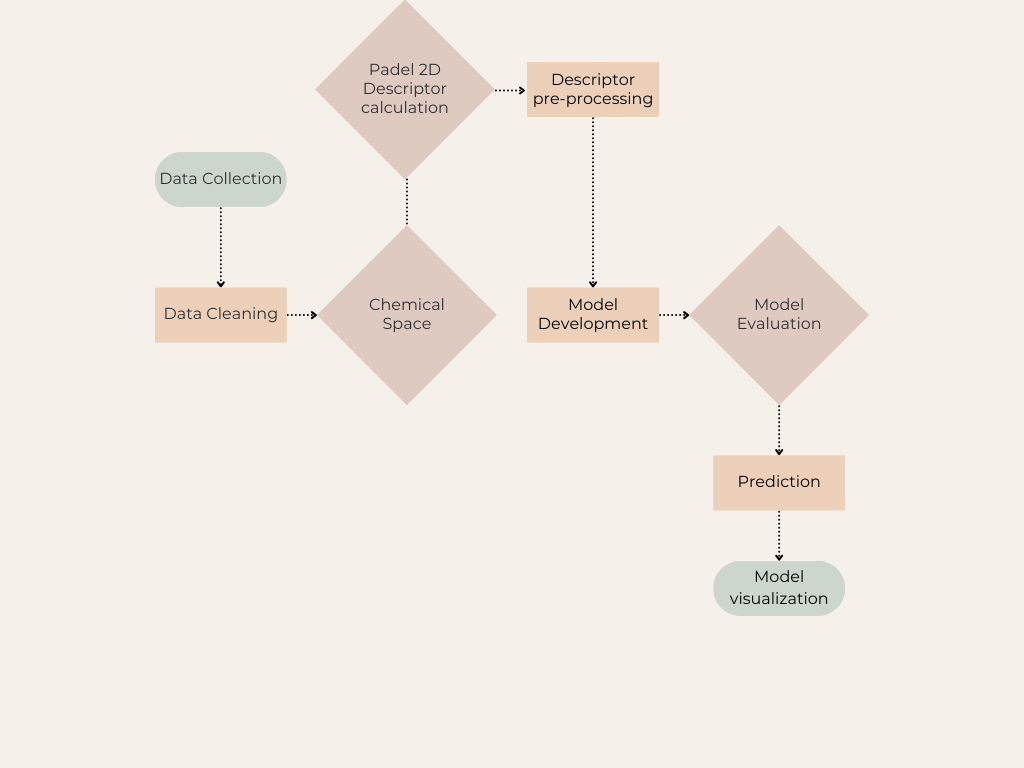


## Installing_libraries
Before we can start it is important that these libraries are installed. The libraries are commented out because they are already installed in my jupyter notebook.
We need the following libaries to be installed. 

- Pandas, Numpy: For data manipulation and analysis.
- Matplotlib & seaborn: For plotting and visualizations.
- RDKit: For cheminformatics tasks.
- Chembl-webresource-client: To access ChEMBL database.
- Tqdm: For progress bars in loops.
- Scikit-learn: For machine learning algorithms.
- XGBoost: For gradient boosting framework.
- LightGBM: For efficient gradient boosting.
- SHAP: For model interpretation using SHAP values.
- Padelpy: For molecular descriptor calculations.


In [1]:
# Using pip to insrall libraries
#pip install pandas seaborn matplotlib rdkit chembl_webresource_client tqdm scikit-learn xgboost lightgbm shap padelpy

# Using conda
#conda install -c conda-forge rdkit

## Importing_libraries

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
from IPython.display import SVG

# RDKit for cheminformatics
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, Lipinski, PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import DataStructs
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from rdkit.Chem import rdmolops


# ChEMBL web resource client
from chembl_webresource_client.new_client import new_client 

# Machine learning libraries|
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor,
                              StackingRegressor, BaggingRegressor, AdaBoostRegressor)
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import xgboost as xgb 
import lightgbm as lgb  

#feature importance
from sklearn.inspection import permutation_importance
import shap
#application domain
from sklearn.metrics import pairwise_distances


from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Padelpy for molecular descriptor calculations
from padelpy import padeldescriptor, from_smiles

# PubChem for chemical information retrieval
import pubchempy as pcp

# Additional libraries for data handling and visualization
import requests
import json
import math
import time  # To check time

# Hide warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set display options for Pandas DataFrames
pd.set_option('display.max_colwidth', None)  # None means no limit
sns.set(style="whitegrid")



<a name="Data_Collection">

# 1) Data Collection
---

_[ChEMBL](https://www.ebi.ac.uk/chembl/) is an Open Data database containing binding, functional and ADMET information for a large number of drug-like bioactive compounds. The data is manually abstracted from the primary published literature on a regular basis, then further curated and standardized to maximize their quality and utility across a wide range of chemical biology and drug-discovery research problems. Currently, the database contains 5.4 million bioactivity measurements for more than 1 million compounds and 5200 protein targets.

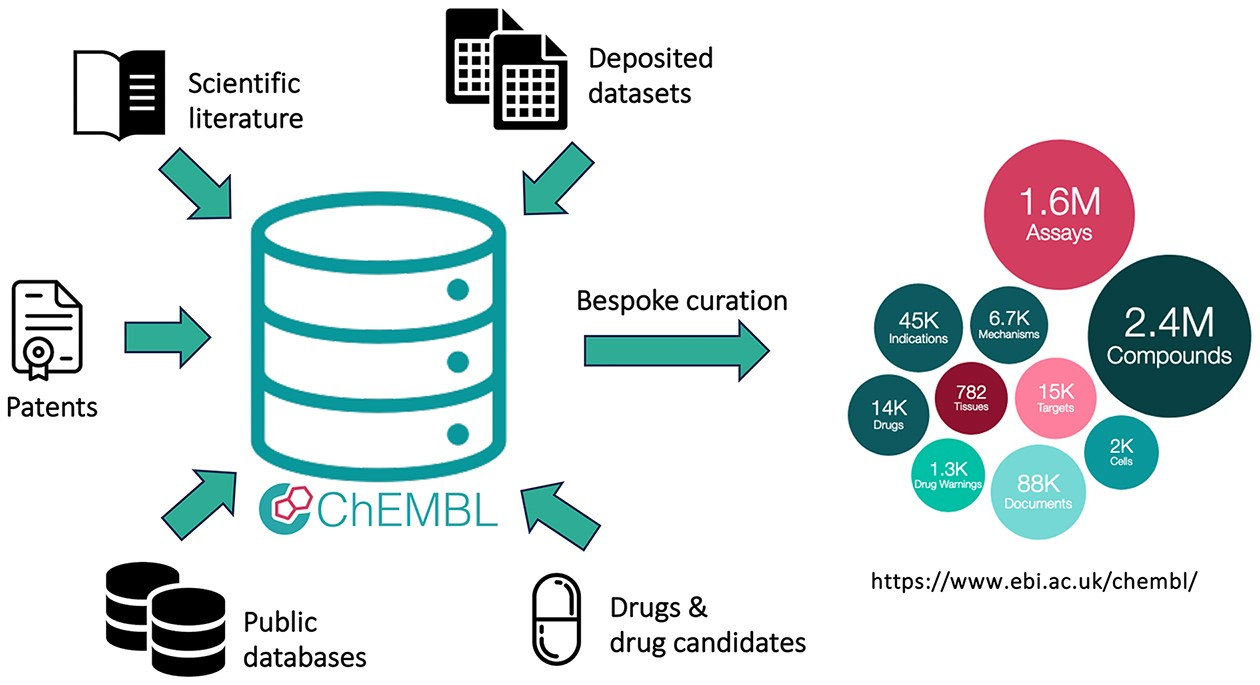 __[zdrazil et al., 2023](https://academic.oup.com/nar/article/52/D1/D1180/7337608)

### ChEMBL data

To ensure consistency in the data collection process, we have frozen the data into a CSV file. For reproducibility load the CSV named "chembl_targets_15_jul.csv" and jump the first step which is commented out. 

In [3]:
# #extract data from Chembl
# # target = new_client.target
# target_query = target.search('tuberculosis')
# targets = pd.DataFrame.from_dict(target_query)
# #preview extracted data
# targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Mycobacterium tuberculosis,Mycobacterium tuberculosis,15.0,False,CHEMBL360,[],ORGANISM,1773
1,[],Mycobacterium tuberculosis H37Rv,Mycobacterium tuberculosis H37Rv,13.0,False,CHEMBL2111188,[],ORGANISM,83332
2,[],Mycobacterium tuberculosis variant bovis,Mycobacterium tuberculosis variant bovis,12.0,False,CHEMBL613086,[],ORGANISM,1765
3,[],Mycobacterium tuberculosis variant microti,Mycobacterium tuberculosis variant microti,12.0,False,CHEMBL612960,[],ORGANISM,1806
4,[],Mycobacterium tuberculosis variant bovis BCG,Mycobacterium tuberculosis variant bovis BCG,10.0,False,CHEMBL615052,[],ORGANISM,33892


Loading the data stored.

In [2]:
# Freeze targets by making a csv
#targets.to_csv('chembl_targets_15_jul.csv')
targets = pd.read_csv('chembl_targets_15_jul.csv')
targets.head(5)

,Unnamed: 0,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,0,[],Mycobacterium tuberculosis,Mycobacterium tuberculosis,15.0,False,CHEMBL360,[],ORGANISM,1773
1,1,[],Mycobacterium tuberculosis H37Rv,Mycobacterium tuberculosis H37Rv,13.0,False,CHEMBL2111188,[],ORGANISM,83332
2,2,[],Mycobacterium tuberculosis variant bovis,Mycobacterium tuberculosis variant bovis,12.0,False,CHEMBL613086,[],ORGANISM,1765
3,3,[],Mycobacterium tuberculosis variant microti,Mycobacterium tuberculosis variant microti,12.0,False,CHEMBL612960,[],ORGANISM,1806
4,4,[],Mycobacterium tuberculosis variant bovis BCG,Mycobacterium tuberculosis variant bovis BCG,10.0,False,CHEMBL615052,[],ORGANISM,33892


In [3]:
targets.shape

(5, 10)

### ChemBl data
We are interested in the data in the first and second rows which represent data from the strain from H37Rv. So I will selct the two rows.  

In [4]:
targets.iloc[[0,1]] #to get the first two rows

,Unnamed: 0,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,0,[],Mycobacterium tuberculosis,Mycobacterium tuberculosis,15.0,False,CHEMBL360,[],ORGANISM,1773
1,1,[],Mycobacterium tuberculosis H37Rv,Mycobacterium tuberculosis H37Rv,13.0,False,CHEMBL2111188,[],ORGANISM,83332


In [5]:
#Selecting the target organism
selected_target1 = targets.target_chembl_id[0] #MTb
selected_target2 = targets.target_chembl_id[1] #Mtb H37RV
selected_target1, selected_target2

('CHEMBL360', 'CHEMBL2111188')

Fitering the standard value according to the IC50

In [6]:
#collecting data for each target
activity = new_client.activity
data1 = activity.filter(target_chembl_id=selected_target1).filter(standard_type='IC50') 
data2 = activity.filter(target_chembl_id=selected_target2).filter(standard_type='IC50')

I will then combine the two datasets into one dataframe

In [7]:
%%time
#converting dictionaries to pandas dataframes
df_1 = pd.DataFrame.from_dict(data1)
df_2 = pd.DataFrame.from_dict(data2)
#concatenating all the dataframes on top of each other (by rows)
df = pd.concat([df_1, df_2], axis=0, ignore_index=True)

Wall time: 3min 39s


In [8]:
#checking the shape of the dataset
df.shape

(2950, 46)

## Data Cleaning- data cleaning is an iterative process. there in this section we:

- transformed all the data of standard value to numeric value. this is important because when its in an object string format, statistical evaluation will not be done on the column.
-deleted 'standard_value' rows with blanks
- The dataset has a column "data_validity_comment" which helps to check the validity of the data captured, therefore, if the data is considered outside range we filtered it out. 
-further, when there are duplicates of the same data by "molecule_chembl_id" we would then take the smallest one.

In [9]:
#transform standard_values to numeric
df['standard_value'] = pd.to_numeric(df['standard_value'], errors='coerce')

In [10]:
# delete blank rows
df= df.dropna(subset=['standard_value'])

In [11]:
# Filter out data 'Outside typical range'
df1 = df[df['data_validity_comment'] != 'Outside typical range']

#Select entry with the lowest standard_value
best_entries = df.groupby('molecule_chembl_id').apply(lambda x: x.nsmallest(1, 'standard_value')).reset_index(drop=True)

# If no valid entries are found, choose to keep the original duplicates 
if best_entries.empty:
    best_entries = df.groupby('molecule_chembl_id').first().reset_index()


In [12]:
best_entries.head(2)

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,16421037,[],CHEMBL3750542,Antimycobacterial activity against Mycobacterium tuberculosis H37Ra ATCC 25177 assessed as growth inhibition after 24 to 168 hrs by microplate resazurin assay,F,None,None,BAO_0000190,...,Mycobacterium tuberculosis,Mycobacterium tuberculosis,1773,None,None,IC50,uM,UO_0000065,None,23.8
1,None,None,25507649,"[{'comments': None, 'relation': '=', 'result_flag': 0, 'standard_relation': '=', 'standard_text_value': None, 'standard_type': 'TIME', 'standard_units': 'hr', 'standard_value': '120.0', 'text_value': None, 'type': 'TIME', 'units': 'day', 'value': '5.0'}]",CHEMBL5333912,Antimycobacterial activity against Mycobacterium tuberculosis HN878 assessed as inhibition of mycobacterial growth incubated for 5 days,F,None,None,BAO_0000190,...,Mycobacterium tuberculosis,Mycobacterium tuberculosis,1773,None,None,IC50,uM,UO_0000065,None,25.0


### Data cleaning cont-

- Now we now filter according to the type of assay. we are only interested in only H37Ra/ H37Rv. the strain are chosen because we will be working with them experimentally.

In [13]:
#Taking only assay with 'h37ra|h37rv'
best_entries =   best_entries[  best_entries['assay_description'].str.contains(r'h37ra|h37rv',
                                                                               case=False, na=False)]

print(f'The shape of the dataset after filtering assay_description is: {best_entries.shape}')

The shape of the dataset after filtering assay_description is: (1378, 46)


From the columns we will select the columns that are of interest to us. Which are molecule_chembl_id', 'canonical_smiles', 'standard_value

In [14]:
#selecting only required columns
selection = ['molecule_chembl_id', 'canonical_smiles', 'standard_value']
best_entries= best_entries[selection]
best_entries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1378 entries, 0 to 1913
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  1378 non-null   object 
 1   canonical_smiles    1378 non-null   object 
 2   standard_value      1378 non-null   float64
dtypes: float64(1), object(2)
memory usage: 43.1+ KB


Summary
- standard_value column
In the data cleaning we managed to make the standard_value into a numeric format, this is because only analysis can only be performed on numbers and not objects.The rows wich had empty rows were deleted.
- data_validity column
This column was used to filter data so that we get compounds that are within the range of what has been repoted by others, meaning data that is outside that had this comment was deleted. 
- Chembl_Id column
It was noticed that some compounds were captured more than twice and we filtered such data taking the IC50 which had lower values.

## Classifying data into active/inactive

According to a research article, the active concentration of isoniazid ranges from 0.1 to 0.2 µg/mL, which is equivalent to approximately 0.00729 to 1.458 µM.  Based on these findings, we will classify compounds as either active or inactive. Specifically, compounds with an IC50 value greater than 1456 nM will be classified as inactive. 

In [15]:
#classify activity into classes
bioactivity_class = []

for i in best_entries['standard_value']:
    if float(i) > 1456:
        bioactivity_class.append("inactive")
    else:  # This covers both equal to and less than 1456
        bioactivity_class.append("active")

# Optionally, you can add this classification as a new column in the DataFrame
best_entries['bioactivity_class'] = bioactivity_class

best_entries = best_entries[['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'bioactivity_class']]
# Display the updated DataFrame
best_entries.head()

#print(df[['molecule_chembl_id', 'canonical_smiles', 'standard_value', 'bioactivity_class']])
 

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class
0,CHEMBL105310,O=C(/C=C/c1ccccc1)c1ccc(O)cc1O,23800.0,inactive
3,CHEMBL1087717,COc1ccc(O)c(-c2csc(N/N=C(\C)c3ccncc3)n2)c1,100.0,active
4,CHEMBL1088462,COc1ccc2c(c1CC=C(C)C)O[C@H]1c3cc(CC=C(C)C)c(O)cc3OC[C@@]21O,12.5,active
5,CHEMBL1089834,COc1ccc2c(c1)[n+]([O-])c(C(=O)NCc1ccccc1)c(C)[n+]2[O-],18870.0,inactive
6,CHEMBL1089835,Cc1c(C(=O)NCc2ccccc2)[n+]([O-])c2cc(Cl)ccc2[n+]1[O-],1100.0,active


In [16]:
#make a copy of df just in case 
df2 = best_entries.copy()

In the cell below, we then visualize the active vs the inactive compounds, of which is represented by the bar graph.

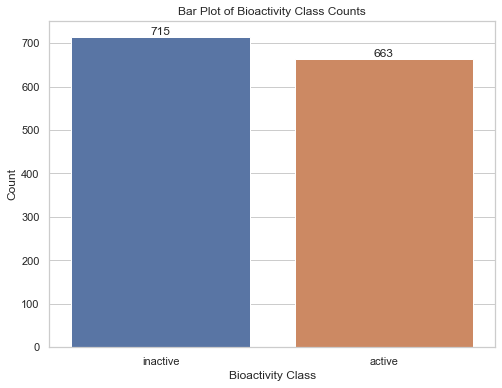

In [17]:
#visualize the class
df2_counts = df2['bioactivity_class'].value_counts()

# Creating a bar plot
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x=df2_counts.index, y=df2_counts.values)
# Add count labels on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(f'{int(p.get_height())}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='bottom')
    
plt.xlabel('Bioactivity Class')
plt.ylabel('Count')
plt.title('Bar Plot of Bioactivity Class Counts')
plt.show()


The plot indicates that 715 compounds of the compounds are active whils 663 compounds inactive. 

-Further, we plot the distribution of the compounds using the standard_value(IC50)


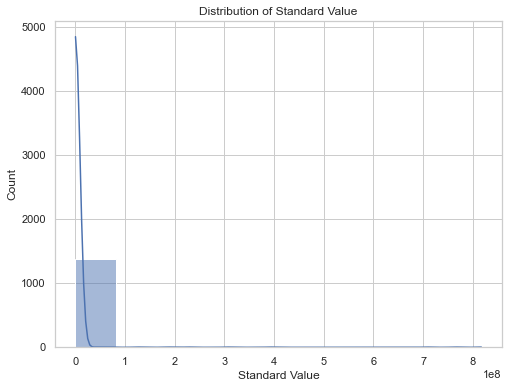

In [18]:
#Creatin a histogram
plt.figure(figsize=(8, 6))
sns.histplot(df2['standard_value'], bins=10, kde=True)  # kde=True adds a kernel density estimate

# Adding labels and title
plt.xlabel('Standard Value')
plt.ylabel('Count')
plt.title('Distribution of Standard Value')

# Display the plot
plt.show()

The distribuion using standard value is diffult to interpret and hence we convert it to the (-log)

In [19]:
#pIc50
df2['pIC50']= 9-np.log10(df2['standard_value'])


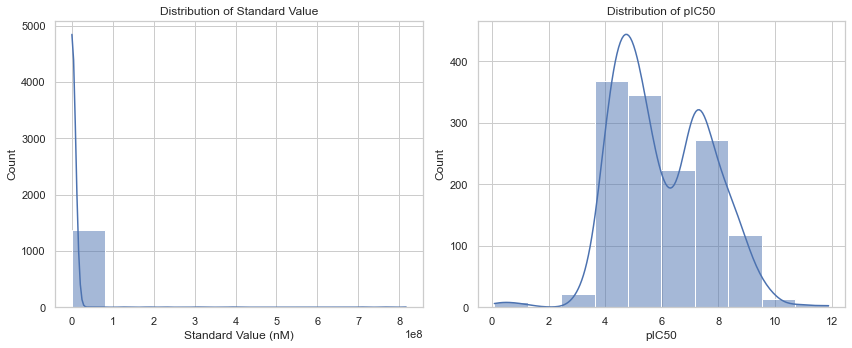

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

#histogram for standard_value
sns.histplot(df2['standard_value'], bins=10, ax=ax1, kde=True)
ax1.set_xlabel('Standard Value (nM)')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Standard Value')

#histogram for pIC50
sns.histplot(df2['pIC50'], bins=10, ax=ax2, kde=True)
ax2.set_xlabel('pIC50')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of pIC50')

fig.savefig('histogram_distribution.png')

plt.tight_layout()
plt.show()

The higher the pIC50 corresponds to the lower IC50.

In [21]:
df2['pIC50'].describe()

count    1378.000000
mean        6.046510
std         1.678095
min         0.087700
25%         4.698970
50%         5.698970
75%         7.440910
max        11.886057
Name: pIC50, dtype: float64

In [22]:
df2.head(2)

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,pIC50
0,CHEMBL105310,O=C(/C=C/c1ccccc1)c1ccc(O)cc1O,23800.0,inactive,4.623423
3,CHEMBL1087717,COc1ccc(O)c(-c2csc(N/N=C(\C)c3ccncc3)n2)c1,100.0,active,7.000000


## Getting Isoniazid derivatives in the dataset

Now that we have explored our datasets, we will then do a substructure search of the compound of interest, which the isoniazid. we further looked at deffrent derivatives of it when doing the substructure search  to ensure that we dont miss any derivative.

1.1 Substructure search using isoniazid smile

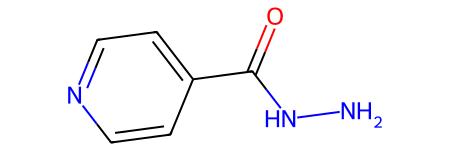

In [23]:
isoniazid_smile = Chem.MolFromSmiles('C1=CN=CC=C1C(=O)NN')
isoniazid_smile

In [24]:
%%time
# List to store results
match_ = []

for index, row in df2.iterrows():
    mol = Chem.MolFromSmiles(row['canonical_smiles'])
    if mol is not None and mol.HasSubstructMatch(isoniazid_smile):
        match = mol.GetSubstructMatch(isoniazid_smile)
        match_.append((index, row['canonical_smiles'], match))

for index, smiles, match in match_:
    print(f"Index: {index}, SMILES: {smiles}, Match: {match}")

matched_indices = [m[0] for m in match_]  
matched_df_1 = df2.loc[matched_indices]      # Filter df3 to include only matched rows

Index: 51, SMILES: N#Cc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1, Match: (19, 20, 21, 22, 23, 18, 16, 17, 15, 14)
Index: 56, SMILES: N=c1c2ncnc(Nc3ccccc3)c2ncn1NC(=O)c1ccncc1, Match: (22, 23, 24, 25, 26, 21, 19, 20, 18, 17)
Index: 59, SMILES: N=c1c2ncnc(Nc3ccc(F)cc3)c2ncn1NC(=O)c1ccncc1, Match: (23, 24, 25, 26, 27, 22, 20, 21, 19, 18)
Index: 63, SMILES: COc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1, Match: (19, 20, 21, 22, 23, 18, 16, 17, 15, 14)
Index: 152, SMILES: Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2ccccc2[n+]1[O-], Match: (9, 10, 11, 12, 13, 8, 6, 7, 5, 4)
Index: 153, SMILES: Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2cc(Cl)ccc2[n+]1[O-], Match: (9, 10, 11, 12, 13, 8, 6, 7, 5, 4)
Index: 154, SMILES: COc1ccc2c(c1)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-], Match: (17, 18, 19, 20, 21, 16, 14, 15, 13, 12)
Index: 155, SMILES: Cc1ccc2c(c1)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-], Match: (16, 17, 18, 19, 20, 15, 13, 14, 12, 11)
Index: 156, SMILES: Cc1cc2c(cc1C)[n+]([O-])c(/C=N/NC(

In [25]:
matched_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 51 to 1905
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  35 non-null     object 
 1   canonical_smiles    35 non-null     object 
 2   standard_value      35 non-null     float64
 3   bioactivity_class   35 non-null     object 
 4   pIC50               35 non-null     float64
dtypes: float64(2), object(3)
memory usage: 1.6+ KB


1.2 Substructure search using isoniazid derivative 1

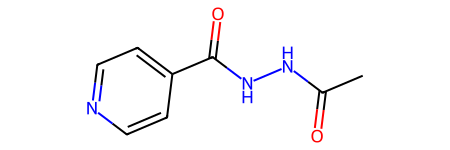

In [26]:
isoniazid_der1 = Chem.MolFromSmiles('C1=CN=CC=C1C(=O)NNC(=O)C')
isoniazid_der1

In [27]:
# List to store results
iso_der1 = []
s
for index, row in df2.iterrows():
    mol = Chem.MolFromSmiles(row['canonical_smiles'])
    if mol is not None and mol.HasSubstructMatch(isoniazid_der1):
        match = mol.GetSubstructMatch(isoniazid_der1)
        iso_der1.append((index, row['canonical_smiles'], match))

for index, smiles, match in iso_der1:

    matched_indices_iso = [m[0] for m in iso_der1]  
    matched_df_der1 = df2.loc[matched_indices_iso]      


In [28]:
matched_df_der1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 619 to 619
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  1 non-null      object 
 1   canonical_smiles    1 non-null      object 
 2   standard_value      1 non-null      float64
 3   bioactivity_class   1 non-null      object 
 4   pIC50               1 non-null      float64
dtypes: float64(2), object(3)
memory usage: 48.0+ bytes


1.3 Substructure search using isoniazid derivative 2

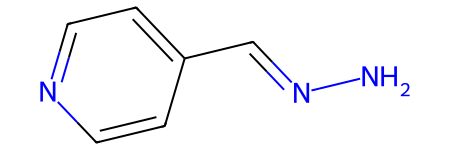

In [29]:
isoniazid_der2 = Chem.MolFromSmiles('C1=CN=CC=C1C=NN')
isoniazid_der2

In [30]:
iso_der2 = []

for index, row in df2.iterrows():
    mol = Chem.MolFromSmiles(row['canonical_smiles'])
    if mol is not None and mol.HasSubstructMatch(isoniazid_der2):
        match = mol.GetSubstructMatch(isoniazid_der2)
        iso_der2.append((index, row['canonical_smiles'], match))

for index, smiles, match in iso_der2:
    
    matched_indices_der2 = [m[0] for m in iso_der2]  
    matched_df_der2 = df2.loc[matched_indices_der2]      


In [31]:
matched_df_der2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25 entries, 3 to 1103
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  25 non-null     object 
 1   canonical_smiles    25 non-null     object 
 2   standard_value      25 non-null     float64
 3   bioactivity_class   25 non-null     object 
 4   pIC50               25 non-null     float64
dtypes: float64(2), object(3)
memory usage: 1.2+ KB


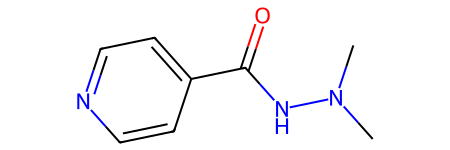

In [32]:
isoniazid_der3 = Chem.MolFromSmiles('C1=CN=CC=C1C(=O)NN(C)C')
isoniazid_der3

In [33]:

iso_der3 = []


for index, row in df2.iterrows():
    mol = Chem.MolFromSmiles(row['canonical_smiles'])
    if mol is not None and mol.HasSubstructMatch(isoniazid_der3):
        match = mol.GetSubstructMatch(isoniazid_der3)
        iso_der3.append((index, row['canonical_smiles'], match))

3
matched_indices_der3 = [m[0] for m in iso_der3]  
matched_der3 = df2.loc[matched_indices_der3]

for index, smiles, match in iso_der3:
    print(f"Index: {index}, SMILES: {smiles}, Match: {match}")



In [34]:
matched_der3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  0 non-null      object 
 1   canonical_smiles    0 non-null      object 
 2   standard_value      0 non-null      float64
 3   bioactivity_class   0 non-null      object 
 4   pIC50               0 non-null      float64
dtypes: float64(2), object(3)
memory usage: 0.0+ bytes


Now, I will then merge all the dfs of the subtructure searches, removing duplicates.

In [35]:
#Now I combine all the df on their indexes

filtered_data = pd.concat([matched_df_1, matched_df_der1, matched_df_der2]).drop_duplicates()
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 51 to 1103
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  60 non-null     object 
 1   canonical_smiles    60 non-null     object 
 2   standard_value      60 non-null     float64
 3   bioactivity_class   60 non-null     object 
 4   pIC50               60 non-null     float64
dtypes: float64(2), object(3)
memory usage: 2.8+ KB


In [36]:
filtered_data = filtered_data.reset_index(drop =True)

In [37]:
filtered_data.set_index('molecule_chembl_id', inplace=True)


In [38]:
filtered_data.head()

,canonical_smiles,standard_value,bioactivity_class,pIC50
molecule_chembl_id,,,,
CHEMBL1170766,N#Cc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,17.20,active,7.764472
CHEMBL1171167,N=c1c2ncnc(Nc3ccccc3)c2ncn1NC(=O)c1ccncc1,4.30,active,8.366532
CHEMBL1172293,N=c1c2ncnc(Nc3ccc(F)cc3)c2ncn1NC(=O)c1ccncc1,0.91,active,9.040959
CHEMBL1172698,COc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,1.59,active,8.798603
CHEMBL1777913,Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2ccccc2[n+]1[O-],1170.00,active,5.931814


In [39]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, CHEMBL1170766 to CHEMBL3782032
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   canonical_smiles   60 non-null     object 
 1   standard_value     60 non-null     float64
 2   bioactivity_class  60 non-null     object 
 3   pIC50              60 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.3+ KB


After the substructure search, the dataset had now 60 rows, and 4 columns. now, i will check if the isoniazid is contained in the filtered data so that if it is there I will not merge it with the data obtained from the pubchem data.

In [40]:
filtered_data.loc[['CHEMBL64']]

,canonical_smiles,standard_value,bioactivity_class,pIC50
molecule_chembl_id,,,,
CHEMBL64,NNC(=O)c1ccncc1,0.0013,active,11.886057


We have the compound then theres no need to merge

In [41]:

PandasTools.AddMoleculeColumnToFrame(filtered_data, smilesCol='canonical_smiles', molCol='molecule')


PandasTools.ChangeMoleculeRendering(renderer='png') 
filtered_data.head()

,canonical_smiles,standard_value,bioactivity_class,pIC50,molecule
molecule_chembl_id,,,,,
CHEMBL1170766,N#Cc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,17.20,active,7.764472,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD270>
CHEMBL1171167,N=c1c2ncnc(Nc3ccccc3)c2ncn1NC(=O)c1ccncc1,4.30,active,8.366532,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD3C0>
CHEMBL1172293,N=c1c2ncnc(Nc3ccc(F)cc3)c2ncn1NC(=O)c1ccncc1,0.91,active,9.040959,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD430>
CHEMBL1172698,COc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,1.59,active,8.798603,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD4A0>
CHEMBL1777913,Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2ccccc2[n+]1[O-],1170.00,active,5.931814,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD510>


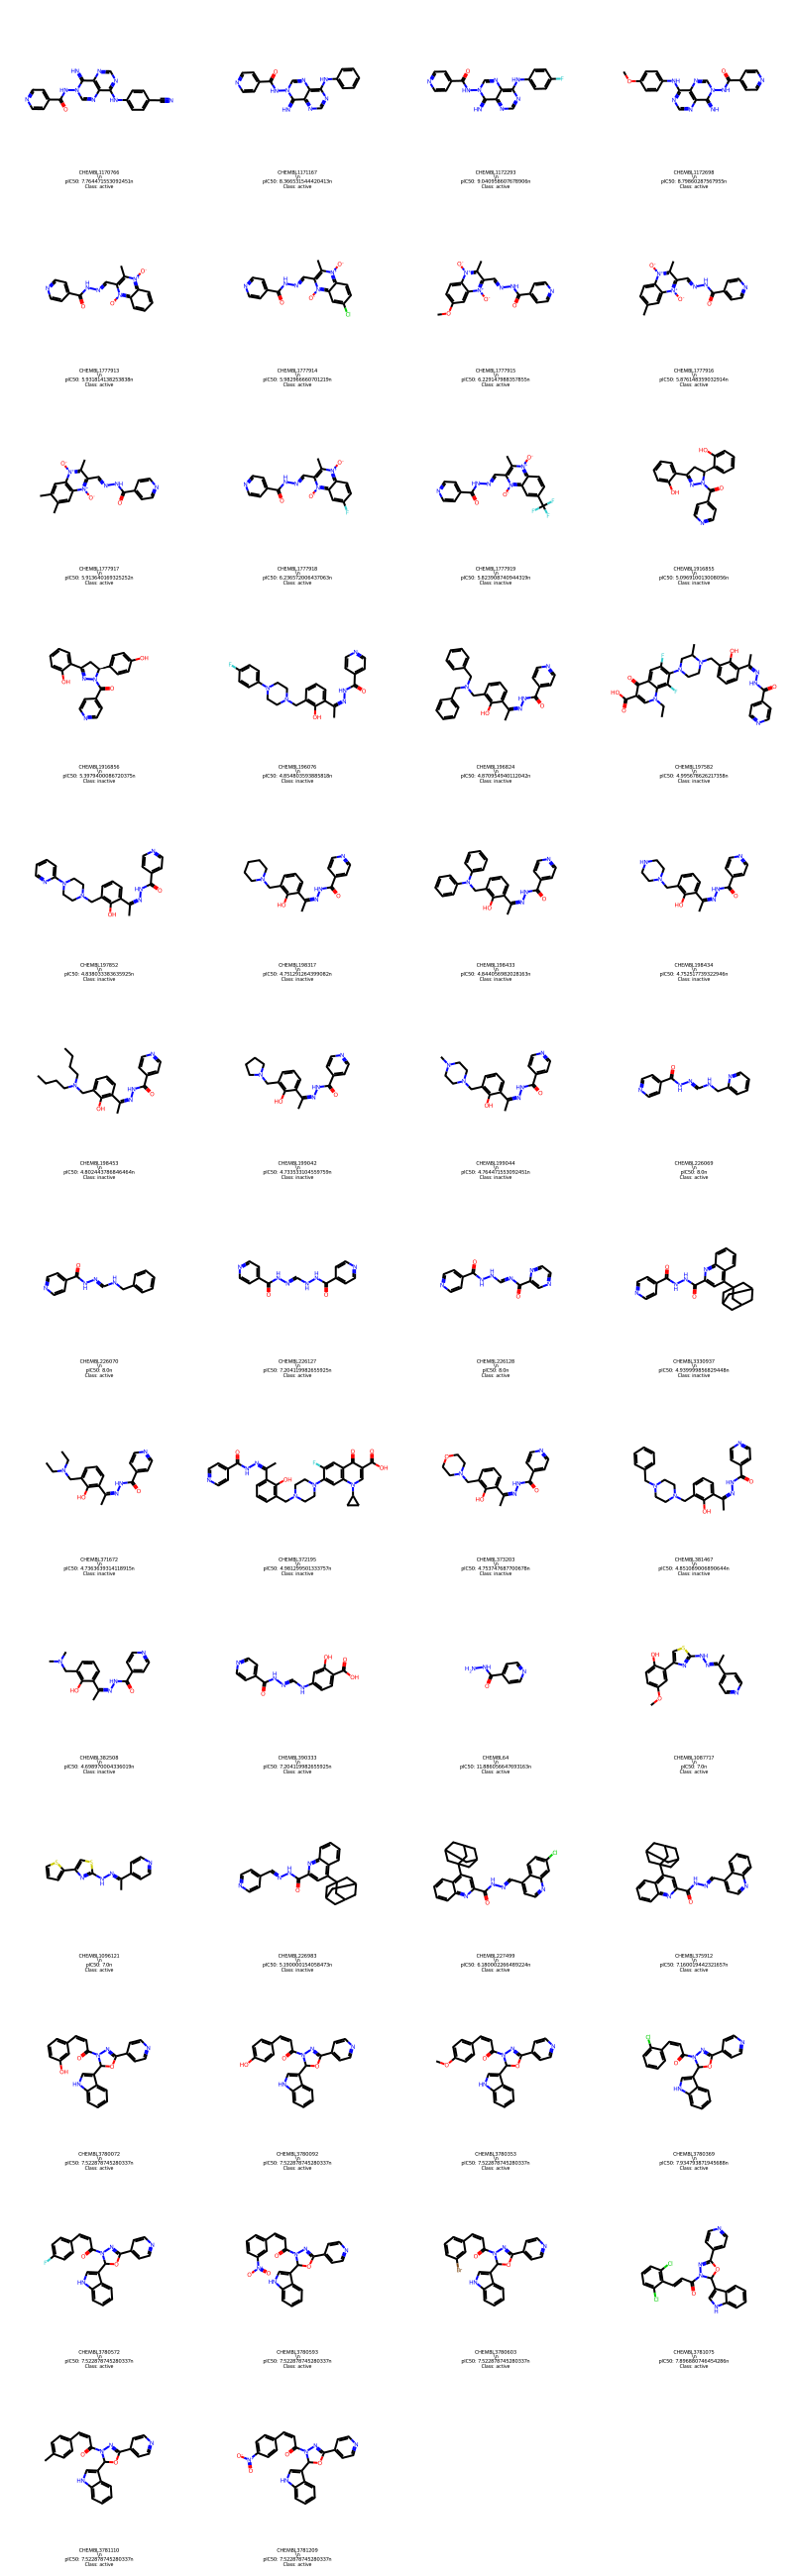

In [42]:
#function to visualize the molecules

legends = [f"{index}\n\n\\n\n\n\npIC50: {row['pIC50']}n\n\n\nClass: {row['bioactivity_class']}" for index, row in filtered_data.iterrows()]
img = Draw.MolsToGridImage(filtered_data['molecule'], 
                            legends=legends, 
                            molsPerRow=4, 
                            subImgSize=(200, 200))

display(img)

The data is now clean and it ready for machine learning

## Machine learning

-The first step is to verify the smiles if they are in the correct format

In [43]:
def validate_smiles(smiles):
    if pd.isna(smiles):  
        return None
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None 
    return smiles  

# Apply the function to the DataFrame
filtered_data['validated_smiles'] = filtered_data['canonical_smiles'].apply(validate_smiles)

# Filter out rows with blanks(Nan)
df_cleaned = filtered_data.dropna(subset=['validated_smiles'])

In [44]:
df_cleaned

,canonical_smiles,standard_value,bioactivity_class,pIC50,molecule,validated_smiles
molecule_chembl_id,,,,,,
CHEMBL1170766,N#Cc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,17.2000,active,7.764472,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD270>,N#Cc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1
CHEMBL1171167,N=c1c2ncnc(Nc3ccccc3)c2ncn1NC(=O)c1ccncc1,4.3000,active,8.366532,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD3C0>,N=c1c2ncnc(Nc3ccccc3)c2ncn1NC(=O)c1ccncc1
CHEMBL1172293,N=c1c2ncnc(Nc3ccc(F)cc3)c2ncn1NC(=O)c1ccncc1,0.9100,active,9.040959,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD430>,N=c1c2ncnc(Nc3ccc(F)cc3)c2ncn1NC(=O)c1ccncc1
CHEMBL1172698,COc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,1.5900,active,8.798603,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD4A0>,COc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1
CHEMBL1777913,Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2ccccc2[n+]1[O-],1170.0000,active,5.931814,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD510>,Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2ccccc2[n+]1[O-]
CHEMBL1777914,Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2cc(Cl)ccc2[n+]1[O-],1040.0000,active,5.982967,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD580>,Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2cc(Cl)ccc2[n+]1[O-]
CHEMBL1777915,COc1ccc2c(c1)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-],590.0000,active,6.229148,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD5F0>,COc1ccc2c(c1)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-]
CHEMBL1777916,Cc1ccc2c(c1)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-],1330.0000,active,5.876148,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD660>,Cc1ccc2c(c1)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-]
CHEMBL1777917,Cc1cc2c(cc1C)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-],1220.0000,active,5.913640,<rdkit.Chem.rdchem.Mol object at 0x00000299302DD6D0>,Cc1cc2c(cc1C)[n+]([O-])c(/C=N/NC(=O)c1ccncc1)c(C)[n+]2[O-]


The SMILES are alright, I will continue with generating descriptors. I will use 2d and Fingerprints

In [45]:
%%time
#create a .smi file
df_cleaned['canonical_smiles'].to_csv('smiles.smi', index=None, header=None) 

Wall time: 18.3 ms


In [46]:
%%timeit

padeldescriptor(mol_dir='smiles.smi', d_file='descriptors_.csv', d_2d=True, d_3d=False, fingerprints=True, retainorder=True,
#                 convert3d=False, #detectaromaticity=True, removesalt=True, retain3d=True,
#                 # standardizenitro=True, standardizetautomers=True
               )

36.8 s ± 1.28 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


The descriptors are now created, I will then load them.

In [47]:
descriptors = pd.read_csv('descriptors_.csv')
descriptors.head()

,Name,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,AUTOGEN_smiles_1,0,-1.4971,2.241308,25.6387,52.810309,22,23,42,29,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_smiles_2,0,-1.5318,2.346411,19.4401,50.617102,22,23,41,27,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_smiles_3,0,-1.0521,1.106914,20.3126,50.507309,22,23,41,28,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_smiles_4,0,-1.5836,2.507789,26.7559,54.512688,22,23,45,29,...,0,0,0,0,0,0,0,0,0,0
4,AUTOGEN_smiles_5,0,-1.0133,1.026777,24.6150,44.734309,16,17,37,24,...,0,0,0,0,0,0,0,0,0,0


In [48]:
#the first column is then droped as it has no value
desc= descriptors.drop(descriptors.columns[0], axis= 1)

In [49]:
desc.head(2)

,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,0,-1.4971,2.241308,25.6387,52.810309,22,23,42,29,13,...,0,0,0,0,0,0,0,0,0,0
1,0,-1.5318,2.346411,19.4401,50.617102,22,23,41,27,14,...,0,0,0,0,0,0,0,0,0,0


### Descriptor preprocessing

In [50]:
def preprocess_descriptors(df):
    """
    a combine function to clean and preprocess the descriptors: 
    -Removes null values
    -convers boolen
    -removes zero variance
    -deletes highly correlated descriptors

    Parameters:
    The DF containing molecular descriptors.

    Returns:
    pandas.DF: The processed DataFrame after applying all preprocessing steps.
    """
    
    # Check for null values and delete
    null_count = df.isnull().sum().sum()  
    if null_count > 0:
        df.dropna(inplace=True)
        print(f"Number of null values deleted: {null_count}")
    else:
        print("No null values found.")

    # Check for object and boolean types
    for column in df.select_dtypes(include=['object', 'bool']).columns:
        if df[column].dtype == 'bool':
            # use dummies 0,1 to convert
            df[column] = df[column].astype(int)
        elif df[column].dtype == 'object':
            # delete rows not object/bolean
            df.drop(columns=column, inplace=True)
            print(f"Deleted non-numeric column: {column}")

    # deleting zero variace values
    def remove_constant_values(df):
        # Identify columns with only one unique value
        constant_columns = [i for i in df.columns if len(df[i].unique()) == 1]
        
    
        new_df = df.drop(columns=constant_columns)
        
        print(f"Number of columns deleted due to constant values: {len(constant_columns)}")
        
        return new_df 

    # Applying the function 
    df = remove_constant_values(df)

    #checking for correlation of descriptors
    def check_correlated_descriptors(df, threshold=0.9):
        correlated_pairs = set()
        
        corr_matrix = df.corr()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                
                if abs(corr_matrix.iloc[i, j]) > threshold:
                    colname = corr_matrix.columns[i]
                    correlated_pairs.add(colname)
        
        return correlated_pairs

    # Check for correlated features with a threshold of 0.9
    corr_features = check_correlated_descriptors(df, 0.9)

    print(f"Number of correlated features found: {len(corr_features)}")

    df = df.drop(columns=corr_features)

    return df  # Return the final processed DataFrame

#timing
start_time = time.time()
processed_df = preprocess_descriptors(desc)

# End time
end_time = time.time()

# Calculate total time taken
total_time = end_time - start_time
print(f"Total time taken for preprocessing: {total_time:.2f} seconds")


processed_df.head()

No null values found.
Number of columns deleted due to constant values: 915
Number of correlated features found: 1004
Total time taken for preprocessing: 26.02 seconds


,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nN,nO,nS,nF,...,PubchemFP721,PubchemFP729,PubchemFP737,PubchemFP738,PubchemFP739,PubchemFP742,PubchemFP750,PubchemFP752,PubchemFP755,PubchemFP759
0,0,-1.4971,2.241308,25.6387,52.810309,22,9,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,-1.5318,2.346411,19.4401,50.617102,22,8,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,-1.0521,1.106914,20.3126,50.507309,22,8,1,0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0,-1.5836,2.507789,26.7559,54.512688,22,8,2,0,0.0,...,1,0,0,0,0,0,0,0,0,0
4,0,-1.0133,1.026777,24.6150,44.734309,16,5,3,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
filtered_data.shape

(60, 6)

In [58]:
# Reset indices 
filtered_data_reset = filtered_data.iloc[:, :4].reset_index(drop=False)
processed_df_reset = processed_df.reset_index(drop=True)

# Concatenate 2 dfs
df_ml = pd.concat([filtered_data_reset, processed_df_reset], axis=1)
df_ml.to_csv('ml_data.csv')

When loading data for ML load using the code below

In [2]:
df= pd.read_csv('ml_data.csv')
df = df.drop(df.columns[0], axis =1)
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,pIC50,nAcid,ALogP,ALogp2,AMR,apol,...,PubchemFP721,PubchemFP729,PubchemFP737,PubchemFP738,PubchemFP739,PubchemFP742,PubchemFP750,PubchemFP752,PubchemFP755,PubchemFP759
0,CHEMBL1170766,N#Cc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,17.20,active,7.764472,0,-1.4971,2.241308,25.6387,52.810309,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL1171167,N=c1c2ncnc(Nc3ccccc3)c2ncn1NC(=O)c1ccncc1,4.30,active,8.366532,0,-1.5318,2.346411,19.4401,50.617102,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL1172293,N=c1c2ncnc(Nc3ccc(F)cc3)c2ncn1NC(=O)c1ccncc1,0.91,active,9.040959,0,-1.0521,1.106914,20.3126,50.507309,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL1172698,COc1ccc(Nc2ncnc3c(=N)n(NC(=O)c4ccncc4)cnc23)cc1,1.59,active,8.798603,0,-1.5836,2.507789,26.7559,54.512688,...,1,0,0,0,0,0,0,0,0,0
4,CHEMBL1777913,Cc1c(/C=N/NC(=O)c2ccncc2)[n+]([O-])c2ccccc2[n+]1[O-],1170.00,active,5.931814,0,-1.0133,1.026777,24.6150,44.734309,...,0,0,0,0,0,0,0,0,0,0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Columns: 411 entries, molecule_chembl_id to PubchemFP759
dtypes: float64(324), int64(84), object(3)
memory usage: 192.8+ KB


In [3]:
df.set_index('molecule_chembl_id', inplace=True)

In [4]:
df = df.drop(columns=['canonical_smiles','standard_value', 'bioactivity_class'])


In [5]:
df.head()

,pIC50,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nN,nO,nS,...,PubchemFP721,PubchemFP729,PubchemFP737,PubchemFP738,PubchemFP739,PubchemFP742,PubchemFP750,PubchemFP752,PubchemFP755,PubchemFP759
molecule_chembl_id,,,,,,,,,,,,,,,,,,,,,
CHEMBL1170766,7.764472,0,-1.4971,2.241308,25.6387,52.810309,22,9,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1171167,8.366532,0,-1.5318,2.346411,19.4401,50.617102,22,8,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1172293,9.040959,0,-1.0521,1.106914,20.3126,50.507309,22,8,1,0,...,0,0,0,0,0,0,0,0,0,0
CHEMBL1172698,8.798603,0,-1.5836,2.507789,26.7559,54.512688,22,8,2,0,...,1,0,0,0,0,0,0,0,0,0
CHEMBL1777913,5.931814,0,-1.0133,1.026777,24.6150,44.734309,16,5,3,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#Regression
y = df['pIC50']

X= df.drop(columns= ['pIC50']) 

check if the assignement of X and y variable is succesful.

In [58]:
#X 

In [59]:
#y

From here, the RF is then used for feature importance. this is to identify the features or descriptors that contribute to the model.

In [7]:
%%time
#Using RF for feature selection
rf_model = RandomForestRegressor()  
rf_model.fit(X, y)

Wall time: 2.19 s


RandomForestRegressor()

Permuation importance
more readeing of can be found here:
https://scikit-learn.org/1.5/modules/permutation_importance.html


In [8]:
#permutation importance
from sklearn.inspection import permutation_importance


results = permutation_importance(rf_model, X, y, n_repeats=30, random_state=42)
importance_df = pd.DataFrame({
    'Feature_perm': X.columns,
    'Importance': results.importances_mean})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df= importance_df.head(10)

,Feature_perm,Importance
169,BCUTw-1l,0.153115
84,AATSC7c,0.039112
291,FMF,0.029432
113,GATS4c,0.024486
34,ATSC7c,0.024153
...,...,...
24,AATS4i,-0.000098
236,nsssN,-0.000121
94,AATSC0p,-0.000137
307,MDEO-11,-0.000161


In [10]:
#getting to features
top_features = importance_df.sort_values(by='Importance', ascending=False)

top_features_top_ten = top_features.head(10)
top_features_top_ten

,Feature_perm,Importance
169,BCUTw-1l,0.153115
84,AATSC7c,0.039112
291,FMF,0.029432
113,GATS4c,0.024486
34,ATSC7c,0.024153
116,GATS7c,0.013797
29,ATSC2c,0.011448
107,MATS1c,0.008424
26,AATS8s,0.006193
139,GATS6p,0.006045


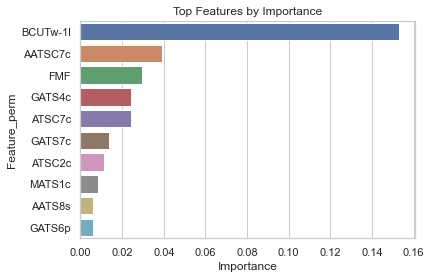

In [12]:
sns.barplot(x='Importance', y='Feature_perm', data= top_features_top_ten)
plt.title('Top Features by Importance')

plt.savefig('important_features_top_ten.png', dpi=500, bbox_inches='tight')


### SHAP
Now that we have the top features, we will then do the SHAP values to see more features that may be contributing to the model.

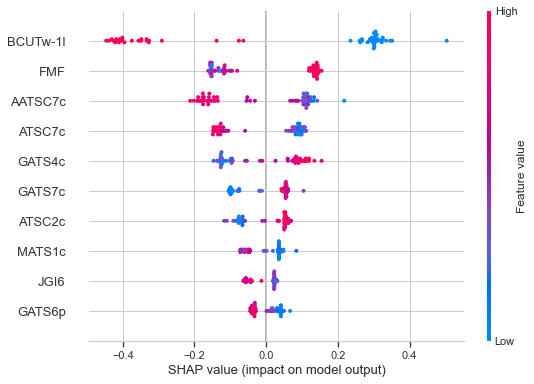

In [37]:
#SHAP
explainer = shap.Explainer(rf_model)
shap_values = explainer(X)

feature_names = X.columns
mean_shap_values = shap_values.values.mean(axis=0)

shap_df = pd.DataFrame({
    'Feature_shap': feature_names,
    'Mean SHAP Value': mean_shap_values
})

top_features_df_ = shap_df.nlargest(10, 'Mean SHAP Value')

top_features_df_.to_csv('top_shap_features.csv', index=False)


shap.summary_plot(shap_values.values, X, max_display=10, show=False)
plt.savefig('shap_values.png', dpi=500, bbox_inches='tight')


In [54]:
#shap features

features_shap = ['BCUTw-1l','FMF', 'AATSC7c', 'ATSC7c',
                 'GATS7c', 'ATSC2c', 'MATS1c', 'JGI6', 'GATS6p', 'ATSC7p']
top_features_permu = ['BCUTw-1l','AATSC7c','FMF','GATS4c','ATSC7c','GATS7c','ATSC2c','MATS1c','AATS8s','GATS6p']
features_to_use = set(features_shap+top_features_permu)
features_to_use =list(features_to_use)
features_to_use

['GATS7c',
 'GATS4c',
 'ATSC7c',
 'GATS6p',
 'FMF',
 'ATSC7p',
 'BCUTw-1l',
 'AATS8s',
 'AATSC7c',
 'ATSC2c',
 'JGI6',
 'MATS1c']

## choosing the best descriptors
this will be done by combining all the descriptors and doing a correlation matrix

In this part, the features that have linear relationship are checked. this was left out

In [42]:
# top_features = X.corrwith(y)

# # Create a DataFrame from the correlation Series
# top_features_df = pd.DataFrame(top_features, columns=['Correlation'])

# # Reset the index to make the feature names a column
# top_features_df.reset_index(inplace=True)
# top_features_df.rename(columns={'index': 'Feature'}, inplace=True)

# # Sort the DataFrame by correlation values in descending order and select the top 10 features
# top_features_corr = top_features_df.sort_values(by='Correlation', ascending=False).head(10)
# top_features_corr

The features all the features are then combined and then we check for VIF

In [55]:
X = df[features_to_use]
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add a constant for intercept
x = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["features"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

# Display the results
print(vif_data)

    features            VIF
0      const  193770.901781
1     GATS7c       5.473698
2     GATS4c       3.495593
3     ATSC7c      13.951464
4     GATS6p       1.889812
5        FMF       3.657394
6     ATSC7p       2.029520
7   BCUTw-1l       6.822013
8     AATS8s       2.856722
9    AATSC7c       6.993150
10    ATSC2c       4.773778
11      JGI6       2.471120
12    MATS1c       5.267221


Then we delete features that have VIF>10

In [56]:
#deleting features with VIF avove 10
vif_data =vif_data[vif_data['VIF'] <= 10]
vif_data

,features,VIF
1,GATS7c,5.473698
2,GATS4c,3.495593
4,GATS6p,1.889812
5,FMF,3.657394
6,ATSC7p,2.029520
7,BCUTw-1l,6.822013
8,AATS8s,2.856722
9,AATSC7c,6.993150
10,ATSC2c,4.773778
11,JGI6,2.471120


In [57]:
features = vif_data['features']
features = features.to_list()
features

['GATS7c',
 'GATS4c',
 'GATS6p',
 'FMF',
 'ATSC7p',
 'BCUTw-1l',
 'AATS8s',
 'AATSC7c',
 'ATSC2c',
 'JGI6',
 'MATS1c']

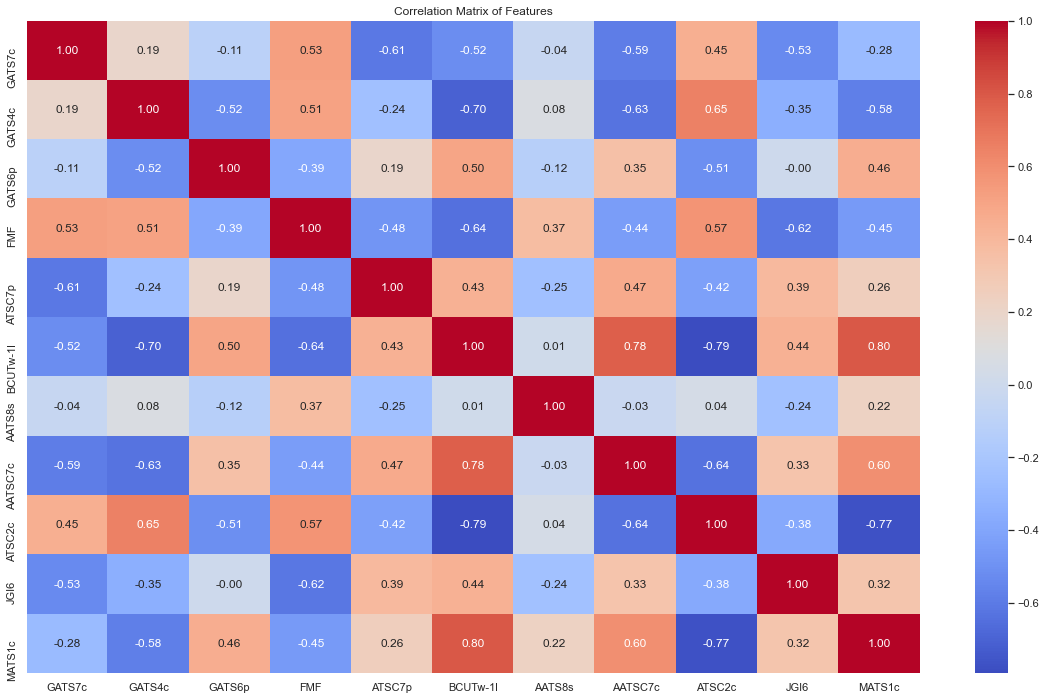

In [58]:
X = df[features]
correlation_matrix = X.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
# Save the figure as a PNG file
plt.savefig('correlation_heatmap.png', dpi=600)
plt.show()


In [59]:
features2 = ['GATS7c','GATS4c',
 'GATS6p','FMF','ATSC7p','BCUTw-1l','AATS8s','JGI6']

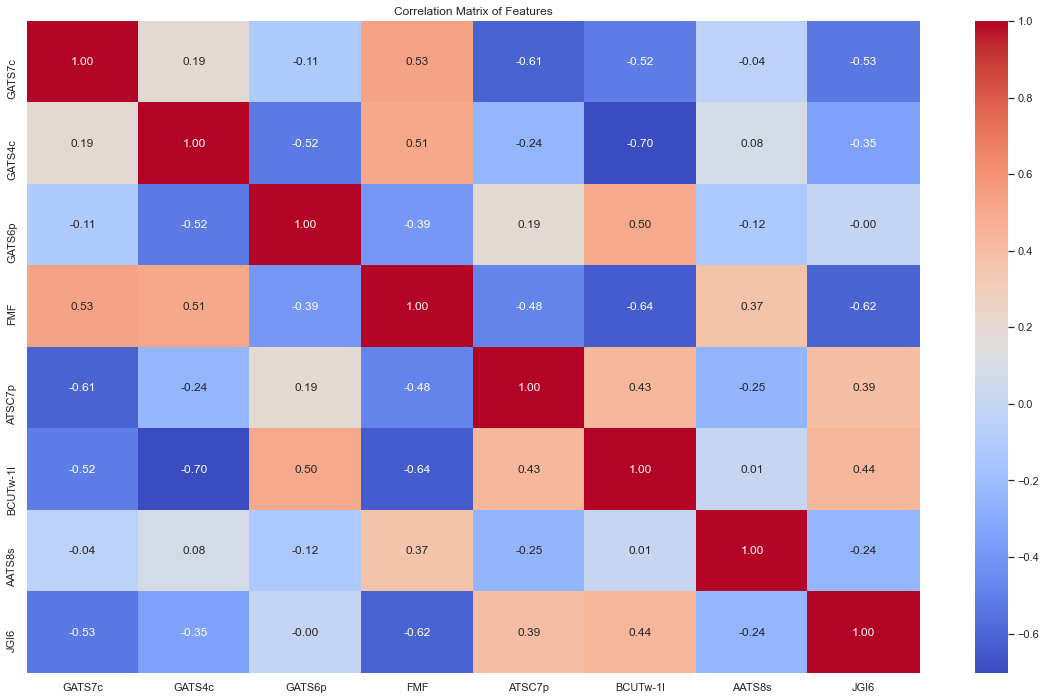

In [61]:
X = df[features2]
correlation_matrix = X.corr()
plt.figure(figsize=(20, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
# Save the figure as a PNG file
plt.savefig('correlation_heatmap2.png', dpi=600)
plt.show()

using all the descriptors I will then check the Permuation inportance of the top 5 descriptors using RF

In [62]:
            
# Select features and target variable
X = df[features2]
y = df['pIC50']

# Scale the features
#scaler = StandardScaler()
#X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=df.index)

In [15]:
#X

In [63]:
rf_model = RandomForestRegressor()  
rf_model.fit(X, y)

RandomForestRegressor()

In [64]:
from sklearn.inspection import permutation_importance


results = permutation_importance(rf_model, X, y, n_repeats=30, random_state=42)

#DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': results.importances_mean})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df.head(10)

,Feature,Importance
5,BCUTw-1l,0.256824
0,GATS7c,0.175819
6,AATS8s,0.100907
1,GATS4c,0.058526
3,FMF,0.058246
4,ATSC7p,0.058129
7,JGI6,0.040055
2,GATS6p,0.032248


In [16]:

features = ['BCUTw-1l', 'GATS7c', 'AATS8s', 'GATS4c', 'GATS8i', 'GATS6p']

In [17]:
X = df[features]
y = df['pIC50']

# Scale the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=df.index)


The chosen scaffolds were chossen to be part or the training data to increase diversity in the train data and alos to make sure that all different substitutions are in the train set.

In [18]:
# Scaffols chosen to make sure they are in the train data
chosen_scaffolds = ['CHEMBL1087717', 'CHEMBL226983', 'CHEMBL3780092', 'CHEMBL3780593', 'CHEMBL196076',
                    'CHEMBL197852', 'CHEMBL226069', 'CHEMBL3330937', 'CHEMBL64', 'CHEMBL1171167',
                    'CHEMBL197852', 'CHEMBL227499', 'CHEMBL1172698', 'CHEMBL390333']  
## Get indices of chosen scaffolds from the DataFrame index
chosen_indices = df.index[df.index.isin(chosen_scaffolds)].tolist()

# Selecting chosen scaffolds from X_scaled and y
X_chosen = X_scaled.loc[chosen_indices]
y_chosen = y.loc[chosen_indices]

# Select remaining data excluding chosen indices
remaining_indices = [i for i in X_scaled.index if i not in chosen_indices]
X_remaining = X_scaled.loc[remaining_indices]
y_remaining = y.loc[remaining_indices]

# train_test_split on the remaining data
X_train_remaining, X_test, y_train_remaining, y_test = train_test_split(
    X_remaining, y_remaining, test_size=0.2, random_state=42)

# Combine chosen scaffolds with the training set from remaining data
X_train = pd.concat([X_chosen, X_train_remaining], ignore_index=False)
y_train = pd.concat([y_chosen, y_train_remaining], ignore_index=False)

print("Final X_train shape:", X_train.shape)
print("Final y_train shape:", y_train.shape)
print("Final X_test shape:", X_test.shape)
print("Final y_test shape:", y_test.shape) 

Final X_train shape: (50, 6)
Final y_train shape: (50,)
Final X_test shape: (10, 6)
Final y_test shape: (10,)


Now that we have have specified the train_test_split, we are ready for ML. firstly, we will visualize the X-train, just to confirm things.

In [75]:
X_train

,BCUTw-1l,GATS7c,AATS8s,GATS4c,FMF
molecule_chembl_id,,,,,
CHEMBL1171167,-0.874051,0.106852,0.431149,1.836352,1.023968
CHEMBL1172698,-0.874051,0.118978,0.441349,1.137342,0.301061
CHEMBL196076,1.149055,-0.676624,-0.532122,-0.998010,-0.552951
CHEMBL197852,1.149107,-1.051708,-0.817078,-0.585168,-0.439920
CHEMBL226069,-0.874051,1.307808,-0.064689,1.525645,0.393683
CHEMBL3330937,-0.874051,1.122936,-0.551050,-1.221336,-0.209961
CHEMBL390333,-0.874051,-0.153802,1.218438,-1.336439,-0.439920
CHEMBL64,-0.874051,-0.168028,-3.611210,0.620282,-2.401339
CHEMBL1087717,-0.874051,0.606457,-0.868917,-0.252165,-0.439920


In [76]:
X_test

,BCUTw-1l,GATS7c,AATS8s,GATS4c,FMF
molecule_chembl_id,,,,,
CHEMBL1096121,-0.874051,1.352844,-1.054386,0.732561,0.810485
CHEMBL3781371,-0.874051,0.776572,-0.234517,1.130685,0.949419
CHEMBL382508,1.149623,-1.966567,-0.561830,-0.672640,-2.145898
CHEMBL3781648,-0.874051,0.751587,-0.208712,0.620643,0.949419
CHEMBL373203,1.149441,-1.173737,-0.725272,-1.555302,-0.717788
CHEMBL3781209,-0.874051,0.746566,0.072575,0.610271,0.627092
CHEMBL197582,1.039241,-1.042106,-0.531623,-1.424711,-1.392609
CHEMBL226070,-0.874051,0.945132,-0.427218,1.347769,0.166337
CHEMBL1777915,1.188800,-0.637177,1.509104,-0.774643,-0.602574


In [19]:
# name of models 
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(),
    'Ridge Regression': Ridge(),
    'Elastic Net': ElasticNet(),
    'Kernel Ridge': KernelRidge(),
    'KNN Regression': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(random_state=1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=1),
    'AdaBoost': AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=50),
    'XGBoost': xgb.XGBRegressor(eval_metric='rmse'),
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor()}

#stacking model with base learners 
base_models = [
    ('rf', RandomForestRegressor(random_state=1)),
    ('ridge', Ridge(random_state=1)),
    ('ada', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=50))
]

stacking_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())
models['Stacking Regressor'] = stacking_model

#bagging model using Decision Tree as base estimator
bagging_model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=1)
models['Bagging Regressor'] = bagging_model

#Function to evaluate a the measuring parameters
def evaluate_model(model):
    y_true_loocv = []
    y_pred_loocv = []

    loo = LeaveOneOut()
    
    for train_index, test_index in loo.split(X):
        X_train_loo, X_test_loo = X.iloc[train_index], X.iloc[test_index]
        y_train_loo, y_test_loo = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train_loo, y_train_loo)
        prediction = model.predict(X_test_loo)

        y_true_loocv.append(y_test_loo.values[0])
        y_pred_loocv.append(prediction[0])

    # Calculate metrics for LOOCV
    mse_loocv = mean_squared_error(y_true_loocv, y_pred_loocv)
    rmse_loocv = np.sqrt(mse_loocv)
    r2_cv = r2_score(y_true_loocv, y_pred_loocv)

    return mse_loocv, rmse_loocv, r2_cv

# results stored a list
results = []


for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_loocv, rmse_loocv, r2_cv = evaluate_model(model)

    results.append({
        'Model': model_name,
        'R² Train': r2_train,
        'R² Test': r2_test,
        'RMSE (LOOCV)': rmse_loocv,
        'R² CV (LOOCV)': r2_cv,
    })


results_df = pd.DataFrame(results)


results_df

,Model,R² Train,R² Test,RMSE (LOOCV),R² CV (LOOCV)
0,Linear Regression,0.834533,0.778103,1.011031,0.533800
1,Lasso Regression,0.165118,0.138995,1.505836,-0.034186
2,Ridge Regression,0.834414,0.792225,0.938191,0.598556
3,Elastic Net,0.533452,0.590272,1.505836,-0.034186
4,Kernel Ridge,-18.576688,-27.317141,0.971331,0.569694
5,KNN Regression,0.771009,0.982179,1.037361,0.509202
6,Random Forest,0.942669,0.970483,0.813935,0.697850
7,Gradient Boosting,0.999781,0.911378,0.814702,0.697281
8,AdaBoost,0.996403,0.973837,0.806885,0.703062
9,XGBoost,1.000000,-0.502981,1.047211,0.499837


In [32]:
results_df.to_csv('regress_results3.csv')

The Adaboost model appears to be the best performing in terms of balance between the train and test variace and and as well as the RCV of which is higher at 70%. now we will check the feature importance/mean effect using the Adaboost.

In [21]:
#AdaBoost
base_estimator = DecisionTreeRegressor(max_depth=3)
adaboost_model = AdaBoostRegressor(base_estimator=base_estimator,
                                   n_estimators=50,
                                   random_state=42)
adaboost_model.fit(X_train, y_train)

# Get feature importances
feature_importances = adaboost_model.feature_importances_
print(feature_importances)

[0.08378913 0.07332533 0.1924895  0.39057142 0.17225974 0.08756488]


Now we want to visualize the scatter plot and see how the models look.

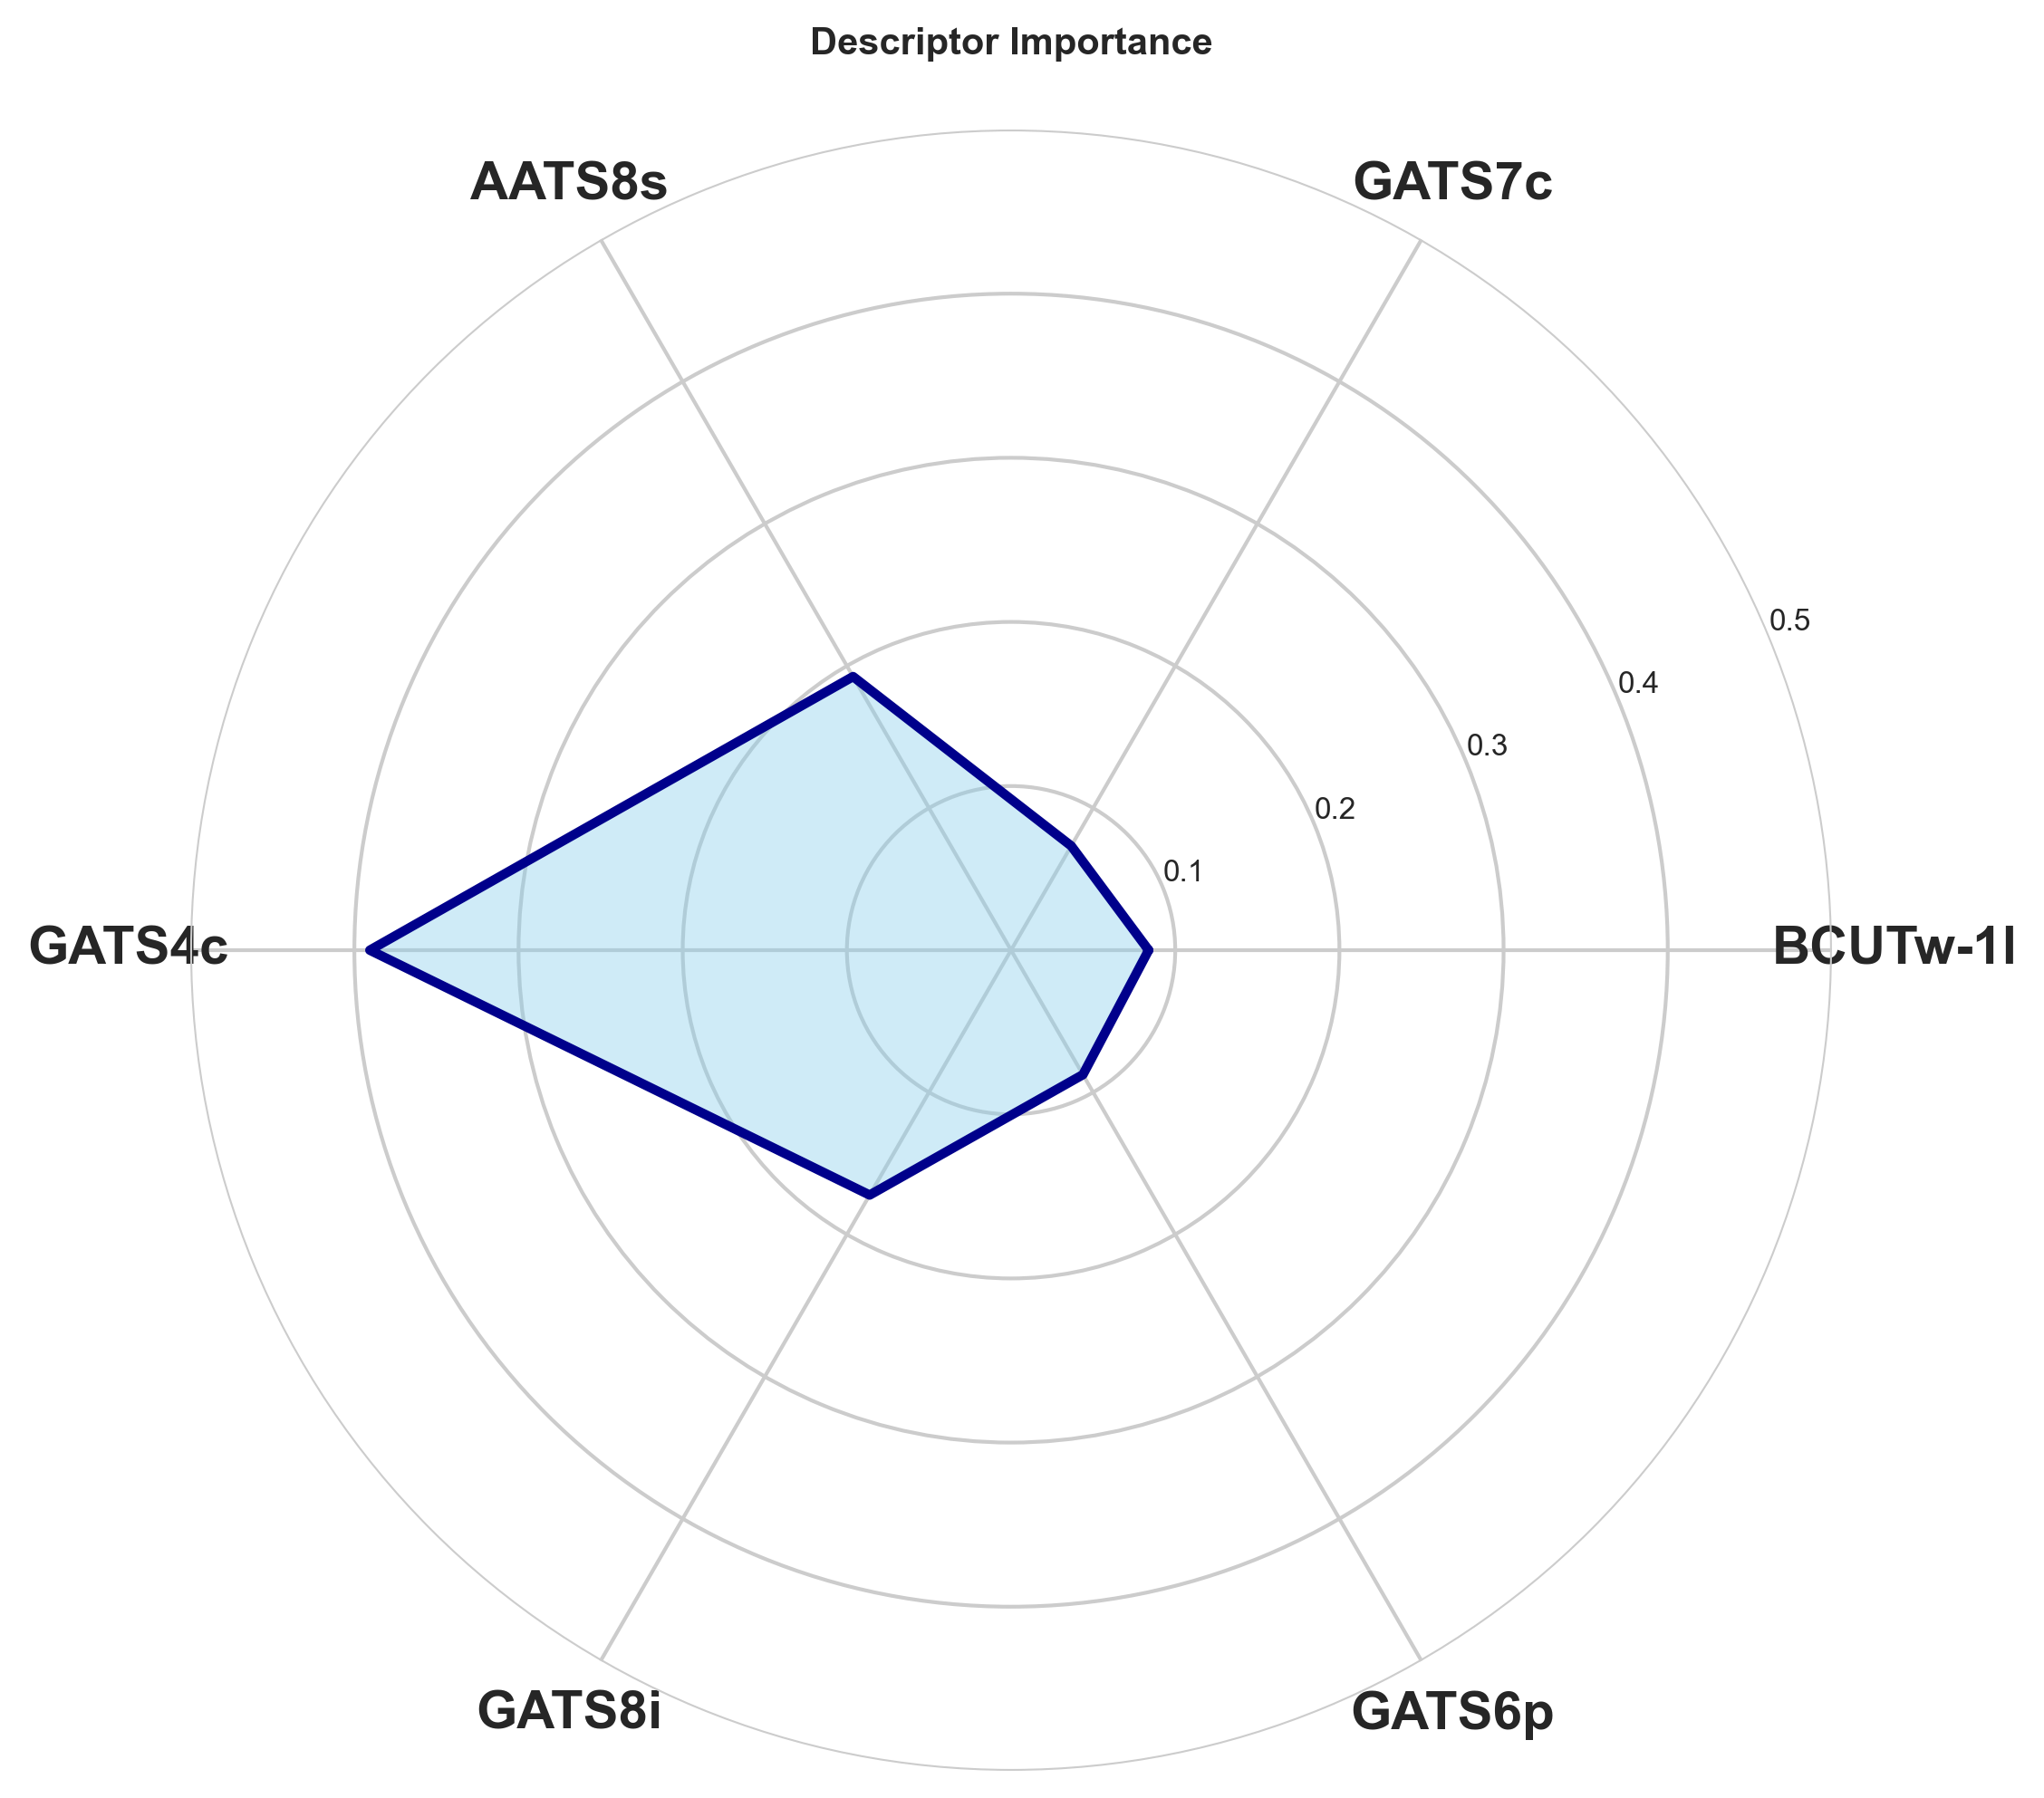

In [141]:
import numpy as np
import matplotlib.pyplot as plt

features = ['BCUTw-1l', 'GATS7c', 'AATS8s', 'GATS4c', 'GATS8i', 'GATS6p']
importance= [0.08378913, 0.07332533, 0.1924895,  0.39057142, 0.17225974, 0.08756488]

 #angle for each axis in radians
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

importance += importance[:1]
angles += angles[:1]


fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True), dpi=300)
ax.plot(angles, importance, color='darkblue', linewidth=2.5, linestyle='solid')
ax.fill(angles, importance, color='skyblue', alpha=0.4)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(features, fontsize=14, fontweight='bold')

ax.set_ylim(0, 0.5)
ax.tick_params(axis='y', labelsize=10)
ax.set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])
ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5'], fontsize=8)


ax.spines['polar'].set_visible(False)

plt.title('Descriptor Importance', fontsize=10, fontweight='bold', pad=20)

plt.savefig('Descriptor_importance_spider_plot.png', bbox_inches='tight', dpi=300)

plt.show()

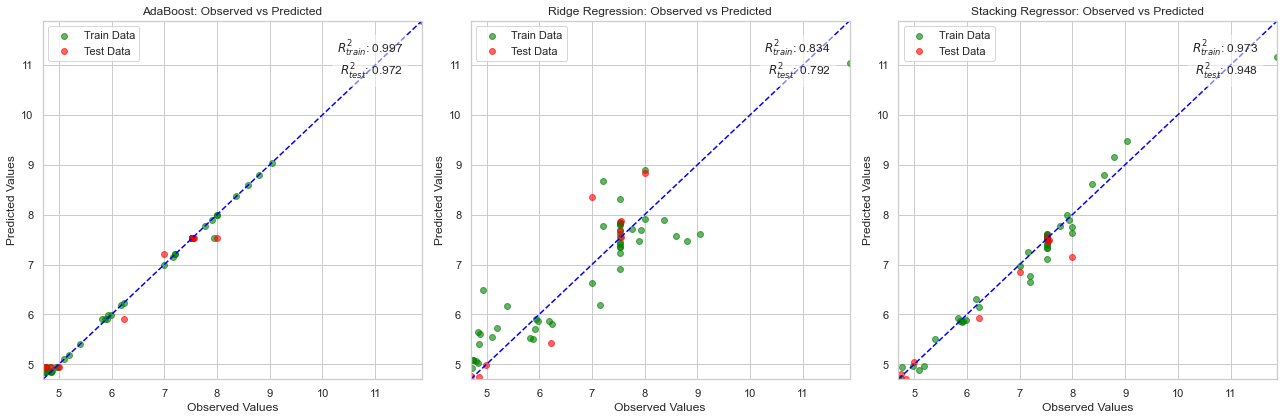

In [25]:
#best_models 
best_models = {
    'AdaBoost': AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=50),
    'Ridge Regression': Ridge(),
    'Stacking Regressor': StackingRegressor(
        estimators=[
            ('rf', RandomForestRegressor(random_state=1)),
            ('ridge', Ridge(random_state=1)),
            ('ada', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=50))
        ],
        final_estimator=LinearRegression()
    )
}

# Training my models again
predictions = {}
for name, model in best_models.items():
    model.fit(X_train, y_train)
    predictions[name] = {
        "train": model.predict(X_train),
        "test": model.predict(X_test)
    }

plt.figure(figsize=(18, 6))
y_min, y_max = min(min(y_train), min(y_test)), max(max(y_train), max(y_test))

for i, (name, preds) in enumerate(predictions.items()):
    plt.subplot(1, 3, i + 1)
    plt.scatter(y_train, preds['train'], color='green', alpha=0.6, label='Train Data')
    plt.scatter(y_test, preds['test'], color='red', alpha=0.6, label='Test Data')
    plt.plot([y_min, y_max], [y_min, y_max], color='blue', linestyle='--') 
    
    r2_train = r2_score(y_train, preds['train'])
    r2_test = r2_score(y_test, preds['test'])

    plt.text(0.95, 0.95, f'$R^2_{{train}}$: {r2_train:.3f}\n$R^2_{{test}}$: {r2_test:.3f}',
         transform=plt.gca().transAxes,
         horizontalalignment='right',
         verticalalignment='top',
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

    plt.title(f'{name}: Observed vs Predicted')
    plt.xlabel('Observed Values')
    plt.ylabel('Predicted Values')
    plt.xlim(y_min, y_max)
    plt.ylim(y_min, y_max)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig('model_scatter_plots_with_r2.png', dpi=500)
plt.show()


We can see that the Adaboost perform the best and we will then calculate the mean effect of which will help to see how much each feature is contributing to the model. 

### Validation
 Validation if the model is divided into two, external and internal. External focuses on the test data, while the internal is the training data. The model is validated according to the OECD principles and using Tropsha
 

### Internal validation
- Most of the parameters such as the R^2,RMSE. Q2 LOO, MAE have already been calculated. therefore, here we will calculate the 
1). Application domain of which According to the OECD principles, a QSAR model should be associated a Application Domain (AD) which can be calculated using the pairwise Euclidean distances between each compound in the training set and those in test set.
2). We will also calculate the y_randomization to make sure that that the prediction is not as a result of a chance.




# ADT
---

In [9]:
X_test

,BCUTw-1l,GATS7c,AATS8s,GATS4c,GATS8i,GATS6p
molecule_chembl_id,,,,,,
CHEMBL1096121,-0.874051,1.352844,-1.054386,0.732561,-1.458197,2.743028
CHEMBL3781371,-0.874051,0.776572,-0.234517,1.130685,0.026868,-0.922051
CHEMBL382508,1.149623,-1.966567,-0.561830,-0.672640,0.862505,-0.130376
CHEMBL3781648,-0.874051,0.751587,-0.208712,0.620643,0.136719,-0.812817
CHEMBL373203,1.149441,-1.173737,-0.725272,-1.555302,1.085863,0.806576
CHEMBL3781209,-0.874051,0.746566,0.072575,0.610271,-0.126638,-0.593452
CHEMBL197582,1.039241,-1.042106,-0.531623,-1.424711,0.240583,1.151934
CHEMBL226070,-0.874051,0.945132,-0.427218,1.347769,-1.282759,-0.559411
CHEMBL1777915,1.188800,-0.637177,1.509104,-0.774643,0.268033,0.463693


In [26]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

# using pairwise Euclidean distances
distance= pairwise_distances(X_train, X_train, metric='euclidean')

#diagonal set to infinity
np.fill_diagonal(distance,np.inf)
#nearest distances
near_distances = np.min(distance, axis =1)
#average distance(D)
average_distance = np.mean(near_distances)
#sigma
sigma = np.std(near_distances)
#Z (set to be 0.5)
Z = 0.5
ADT = average_distance+ Z*sigma

print("Average Distance (D):", average_distance)
print("(Standard Deviation(σ) nearest_distances):", sigma)
print("Applicability Domain Threshold (ADT):", ADT)


Average Distance (D): 0.915115271727028
(Standard Deviation(σ) nearest_distances): 0.9040516766404952
Applicability Domain Threshold (ADT): 1.3671411100472757


In [27]:
compare_dist = pairwise_distances(X_test_scaled, X_train, metric='euclidean')
compare_dist_nearest = np.min(compare_dist)
print(compare_dist_nearest)
if compare_dist_nearest > ADT:
    result = 'predictionunreliable'
else:
    result = 'prediction reliable'
print(result)

0.38126796970811466
prediction reliable


In [12]:
X_train

,BCUTw-1l,GATS7c,AATS8s,GATS4c,GATS8i,GATS6p
molecule_chembl_id,,,,,,
CHEMBL1171167,-0.874051,0.106852,0.431149,1.836352,0.055325,-0.105750
CHEMBL1172698,-0.874051,0.118978,0.441349,1.137342,0.245064,-0.368424
CHEMBL196076,1.149055,-0.676624,-0.532122,-0.998010,0.129560,0.534696
CHEMBL197852,1.149107,-1.051708,-0.817078,-0.585168,0.729538,1.075105
CHEMBL226069,-0.874051,1.307808,-0.064689,1.525645,-1.168139,-0.103387
CHEMBL3330937,-0.874051,1.122936,-0.551050,-1.221336,0.197230,1.213523
CHEMBL390333,-0.874051,-0.153802,1.218438,-1.336439,-2.035295,-1.179282
CHEMBL64,-0.874051,-0.168028,-3.611210,0.620282,-5.676182,-1.388045
CHEMBL1087717,-0.874051,0.606457,-0.868917,-0.252165,-0.040989,3.595670


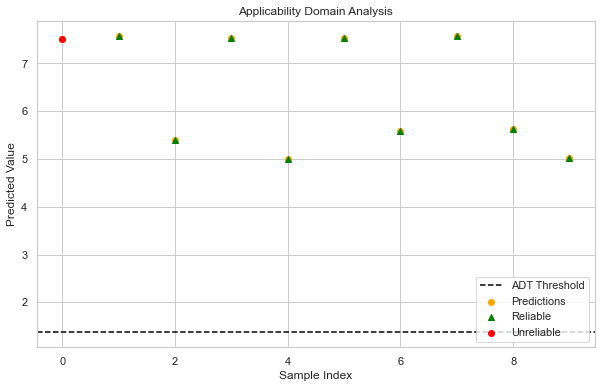

In [28]:
from scipy.spatial import distance_matrix

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = X_test_scaled
predictions = adaboost_model.predict(X_test_scaled)

ADT = average_distance+ Z*sigma

new_distances = distance_matrix(X_test_scaled, X_train_scaled)
new_nearest_distances = np.min(new_distances, axis=1)  
within_ad = new_nearest_distances <= ADT
reliable_predictions = predictions[within_ad]
unreliable_predictions = predictions[~within_ad]

plt.figure(figsize=(10, 6))
plt.scatter(range(len(predictions)), predictions, color='orange', label='Predictions')
plt.scatter(np.where(within_ad)[0], reliable_predictions, color='green', marker='^', label='Reliable')
plt.scatter(np.where(~within_ad)[0], unreliable_predictions, color='red', marker='o', label='Unreliable')
plt.axhline(y=ADT, color='black', linestyle='--', label='ADT Threshold')
plt.title('Applicability Domain Analysis')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.legend(loc='lower right')



#df_results.to_csv('predictions_with_reliability.csv', index=False)

plt.savefig('applicability_domain_analysis.png', dpi=300, bbox_inches='tight')

plt.show()


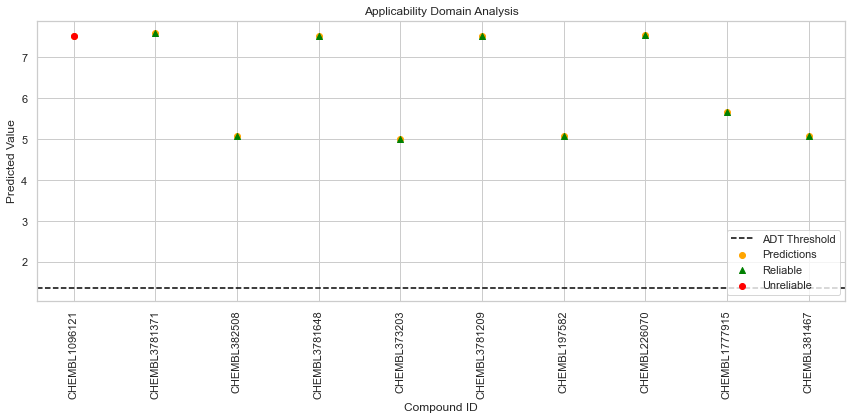

In [29]:
# i want to see the index

test_indices = X_test.index.to_numpy() 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

predictions = adaboost_model.predict(X_test_scaled)

ADT = average_distance + Z * sigma

new_distances = distance_matrix(X_test_scaled, X_train_scaled)
new_nearest_distances = np.min(new_distances, axis=1) 
within_ad = new_nearest_distances <= ADT

reliable_predictions = predictions[within_ad]
unreliable_predictions = predictions[~within_ad]

df_results = pd.DataFrame({
    'Compound_ID': test_indices,
    'Prediction': predictions,
    'Reliable': within_ad
})
df_results.to_csv('predictions_with_reliability.csv', index=False)


plt.figure(figsize=(12, 6))
plt.scatter(test_indices, predictions, color='orange', label='Predictions')
plt.scatter(test_indices[within_ad], reliable_predictions, color='green', marker='^', label='Reliable')
plt.scatter(test_indices[~within_ad], unreliable_predictions, color='red', marker='o', label='Unreliable')
plt.axhline(y=ADT, color='black', linestyle='--', label='ADT Threshold')
plt.title('Applicability Domain Analysis')
plt.xlabel('Compound ID')
plt.ylabel('Predicted Value')
plt.legend(loc='lower right')


plt.xticks(rotation=90)


plt.tight_layout()
plt.savefig('applicability_domain_analysis.png', dpi=300)
plt.show()


y-shuffling
here,We want to check if the model is due to chance.

In [30]:
ypred =adaboost_model.predict(X_train)  
original_r2 = r2_score(y_train, ypred)

print("Original R²:",original_r2 )

shuffled_r2 = []  

for i in range(1000): 
    # Shuffling y_train..doing it 1000 times
    y_train_shuffled = y_train.sample(frac=1, random_state=i).reset_index(drop=True)  
    

    ypred_shuffled = adaboost_model.predict(X_train)  
    shuffled_r2.append(r2_score(y_train_shuffled, ypred_shuffled))
    
mean_shuffled_r2 = np.mean(shuffled_r2)
std_shuffled_r2 = np.std(shuffled_r2)


# Calculating cRp^2
R_r_squared = mean_shuffled_r2  
print("mean_shuffled_r^2 is:", R_r_squared)
cRp_squared = original_r2 * np.sqrt(original_r2 - R_r_squared)

#cRp^2 result
print("Adjusted Correlation Coefficient (cRp^2):", cRp_squared)

# checking acceptable leves , 05 of cRp^2
if cRp_squared > 0.5:
    print("The QSAR model is acceptable (cRp^2 > 0.5).")
else:
    print("The QSAR model is not acceptable (cRp^2 ≤ 0.5).")



# Checking if original R² is significantly higher than mean shuffled R²
if original_r2 > mean_shuffled_r2:
    print("The model's performance is significantly better than chance.")
else:
    print("The model's performance is not significantly better than chance.")
    
# Evaluate Adaboost usimg R²
def evaluate_model(model):
    y_true_loocv = []
    y_pred_loocv = []

    loo = LeaveOneOut()
    
    for train_index, test_index in loo.split(X):
        X_train_loo, X_test_loo = X.iloc[train_index], X.iloc[test_index]
        y_train_loo, y_test_loo = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train_loo, y_train_loo)
        prediction = model.predict(X_test_loo)

        y_true_loocv.append(y_test_loo.values[0])
        y_pred_loocv.append(prediction[0])

    # Calculating metrics for LOOCV
    mse_loocv = mean_squared_error(y_true_loocv, y_pred_loocv)
    rmse_loocv = np.sqrt(mse_loocv)
    r2_cv = r2_score(y_true_loocv, y_pred_loocv)

    return mse_loocv, rmse_loocv, r2_cv

results = []

Original R²: 0.9829423340042852
mean_shuffled_r^2 is: -0.9123299311189453
Adjusted Correlation Coefficient (cRp^2): 1.3532057783372853
The QSAR model is acceptable (cRp^2 > 0.5).
The model's performance is significantly better than chance.


## Golbraikh and Tropsha
---

In [31]:
#comparing R2 to the threshold 0.5
print('R^2 vs observed:', original_r2)
if original_r2 > 0.5:
    print(f"Q² is: {original_r2} therefore it is above 0.5 threshold and it is acceptable")
else:
    print(f"Q² is: {original_r2} therefore it is below 0.5 threshold and it is NOT acceptable")

# Calculation for adjusted R-squared
n = len(y_train) 
k = X_train.shape[1]  

adjusted_r_squared = 1 - ((1 - original_r2) * (n - 1)) / (n - k - 1)
print("Adjusted R^2:", adjusted_r_squared)
closeness = (original_r2 - adjusted_r_squared) /  original_r2
print(f'closeness is: {closeness}')

if closeness < 0.1:
    print(f"Closeness condition (R² - r₀²) / R² < 0.1 is satisfied.")
else:
    print("closeness condition (R² - r₀²) / R² > 0.1 is NOT satisfied.")

# Stability condition check, threshold = 0.3
stability = abs(original_r2  - adjusted_r_squared)
print(f'stability is: {stability}')
if stability < 0.3:
    print("Stability condition |R² - Adjusted R²| < 0.3 is satisfied.")
else:
    print("Stability condition |R² - Adjusted R²| > 0.3 is NOT satisfied.")
    mean_pred = np.mean(ypred)

    mean_true = np.mean(y_train)

#slope k using covariance and variance
k = np.cov(ypred, y_train)[0][1] / np.var(ypred)
print("Slope (k) of predicted vs observed at zero intercept:", k)

#slope (k') of observed vs predicted at zero intercept
k_prime = np.cov(y_train, ypred)[0][1] / np.var(y_train)
print("Slope (k') of observed vs predicted at zero intercept:", k_prime)




R^2 vs observed: 0.9829423340042852
Q² is: 0.9829423340042852 therefore it is above 0.5 threshold and it is acceptable
Adjusted R^2: 0.9805621945630227
closeness is: 0.0024214436177210147
Closeness condition (R² - r₀²) / R² < 0.1 is satisfied.
stability is: 0.0023801394412624743
Stability condition |R² - Adjusted R²| < 0.3 is satisfied.
Slope (k) of predicted vs observed at zero intercept: 1.0615380749027492
Slope (k') of observed vs predicted at zero intercept: 0.9657533188210842


References
1. Jackson, C.M., Esnouf, M.P., Winzor, D.J. and Duewer, D.L., 2007. Defining and measuring biological activity: applying the principles of metrology. Accreditation and quality assurance, 12, pp.283-294.
Swinney, D.C., 2011. Molecular mechanism of action (MMoA) in drug discovery. In Annual Reports in Medicinal Chemistry (Vol. 46, pp. 301-317). Academic Press.
2. Chitale, P., Lemenze, A.D., Fogarty, E.C., Shah, A., Grady, C., Odom-Mabey, A.R., Johnson, W.E., Yang, J.H., Eren, A.M., Brosch, R. and Kumar, P., 2022. A comprehensive update to the M ycobacterium tuberculosis H37Rv reference genome. Nature communications, 13(1), p.7068.
3. Rácz, A., Bajusz, D. and Héberger, K., 2019. Intercorrelation limits in molecular descriptor preselection for QSAR/QSPR. Molecular informatics, 38(8-9), p.1800154.
